In [11]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    rate = dat[:,2]
    return time,dtheta,rate    

def get_centerline(y,Rij): # either R11 or R22 as a vector
    idx = np.argmax(Rij)
    return y[idx],idx
   
def linear_fit(time,dtheta,tstart,tend):
    ts = which_tID(time,tstart)
    te = which_tID(time,tend)+1
    t_fit = time[ts:te]
    dat_fit = dtheta[ts:te]
    growth_rate,shift = np.polyfit(t_fit, dat_fit, 1) #linear fit
    return t_fit,growth_rate,shift

def get_pbars(flist_plot,plotOpt=False):
    mat = np.zeros([len(flist_plot),3])
    counter = 0

    for fname in flist_plot:
        tID = fname.split('_')[-1]
        tID = tID.split('.dat')[0]
        time = nml.read_time(directory,tID)

        # Get pbar
        pbar = np.fromfile(fname,dtype=float, count=-1, sep=' ')
        if plotOpt: ax[0].plot(y,pbar,alpha=0.5)
        
        shift = Ny/10
        mat[counter,0] = time
        mat[counter,1] = pbar[-shift]
        mat[counter,2] = pbar[shift]
        counter += 1
    return mat

In [12]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*pbar*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['shearlayer_pbar_0012.dat', 'shearlayer_pbar_0013.dat', 'shearlayer_pbar_0014.dat', 'shearlayer_pbar_0015.dat', 'shearlayer_pbar_0016.dat', 'shearlayer_pbar_0017.dat', 'shearlayer_pbar_0018.dat', 'shearlayer_pbar_0019.dat', 'shearlayer_pbar_0020.dat']


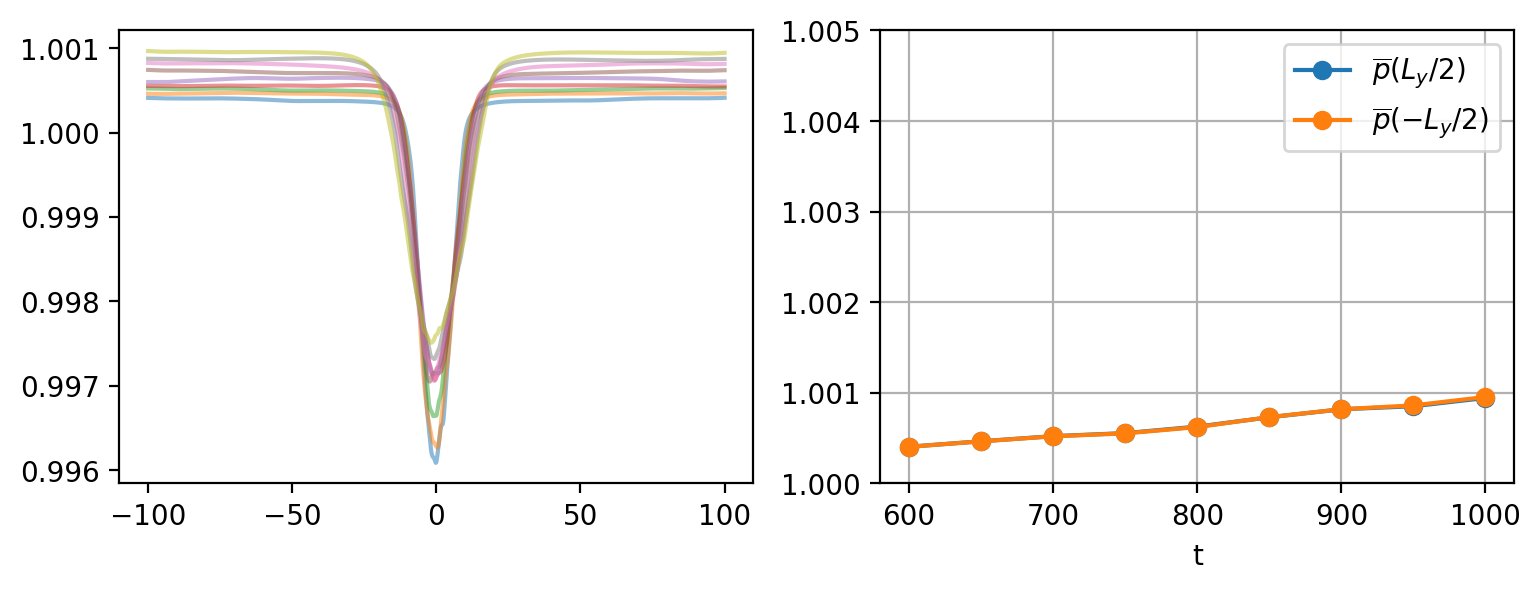

In [3]:
# pbar profiles
    
fig,ax = plt.subplots(1,2,figsize=(9,3), dpi=200)
flist_plot = flist[::]
mat = get_pbars(flist_plot,plotOpt=True)

ax[1].plot(mat[:,0],mat[:,1],'-o',color='C0',label=r'$\overline{p}(L_y/2)$')
ax[1].plot(mat[:,0],mat[:,2],'-o',color='C1',label=r'$\overline{p}(-L_y/2)$')
ax[1].legend()
ax[1].set_ylim([1,1.005])
ax[1].set_xlabel('t')
ax[1].set_xlabel('t')
ax[1].grid(True)
plt.savefig(directory+'/img/pbar.png',dpi=200)

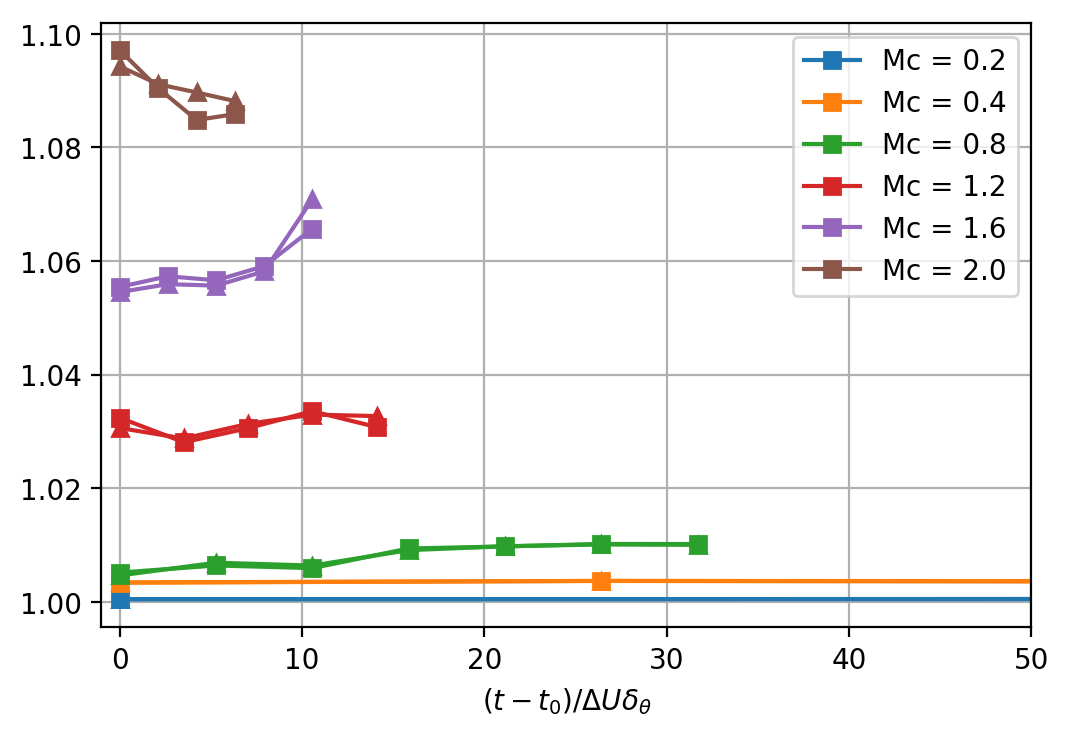

In [13]:
# Compare pressure histories: s=1
fig = plt.figure(figsize=(6,4),dpi=200)

Mc_list = [2,4,8,12,16,20]

for Mc,i in zip(Mc_list,range(len(Mc_list))):
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%02d/rr1/1024x1448x512/'%Mc
    inp = nml.inputs(directory,verbose=False)
    flist = glob.glob(directory+"*pbar*")
    flist.sort()
    mat = get_pbars(flist[1:])
    
    time = (mat[:,0]-mat[0,0])/inp.du
    pbar1 = mat[:,1]
    pbar2 = mat[:,2]
    c = 'C{}'.format(i)
    plt.plot(time,pbar1,'-s',color=c,label='Mc = {}'.format(Mc*0.1)) #upper: squares
    plt.plot(time,pbar2,'-^',color=c) #lower

plt.xlabel(r'$(t-t_0)/\Delta U \delta_{\theta}$')
plt.grid(True)
plt.xlim([-1,50])
plt.legend()
plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/pbar.png',dpi=200)

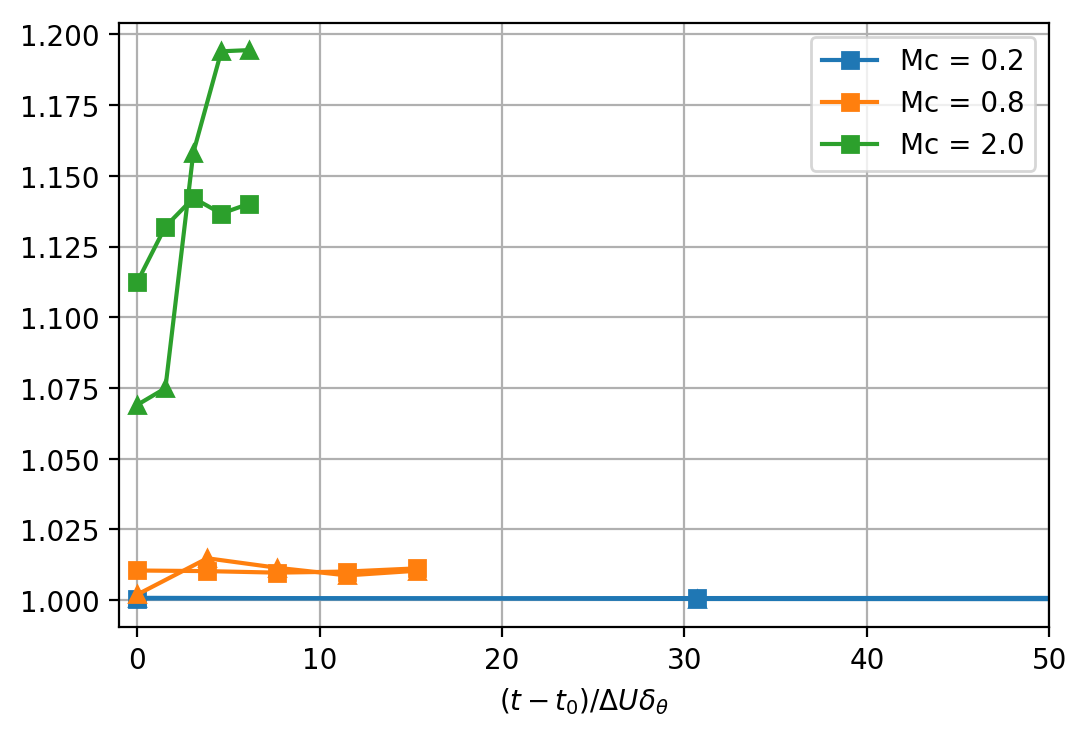

In [9]:
# Compare pressure histories: s=7
fig = plt.figure(figsize=(6,4),dpi=200)

Mc_list = [2,8,20]
s = '_7'
for Mc,i in zip(Mc_list,range(len(Mc_list))):
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%02d/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    flist = glob.glob(directory+"*pbar*")
    flist.sort()
    mat = get_pbars(flist[1:])
    
    time = (mat[:,0]-mat[0,0])/inp.du
    c = 'C{}'.format(i)
    plt.plot(time,mat[:,1],'-s',color=c,label='Mc = {}'.format(Mc*0.1))
    plt.plot(time,mat[:,2],'-^',color=c)

plt.xlabel(r'$(t-t_0)/\Delta U \delta_{\theta}$')
plt.grid(True)
plt.xlim([-1,50])
plt.legend()
plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/pbar_%s.png'%s,dpi=200)

In [4]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'
filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
reader.step = 7

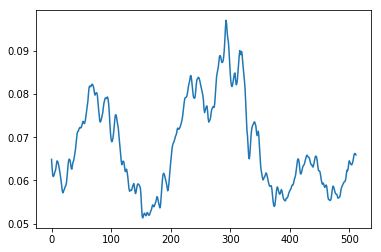

In [10]:
q = reader.readData('p')
qbar = np.mean(np.mean(q[0],axis=2),axis=0)
qp = q[0]-qbar[None,:,None]
qpqp = np.mean(np.mean(qp*qp,axis=2),axis=1)

plt.plot(qpqp)